In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Embedding , concatenate , LSTM,Conv1D
from tensorflow.keras.models import Model
import random as rn
import os

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
path_ = ''
data = pd.read_csv(path_ + 'preprocessed_data.csv' )

In [4]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [7]:
data.shape

(109248, 9)

In [8]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X_train , X_test , y_train , y_test = train_test_split( X , y , test_size=0.33,stratify=y)

In [10]:
X_train.shape , y_train.shape , X_test.shape

((73196, 8), (73196,), (36052, 8))

In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
"""
input_layer = Input(shape=(n,))
embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
#embedding_layr1 = Embedding( vocab_size , vec_size , input_length=max_length , weights=[word_vector_matrix] )( input_layer1 )

flatten = Flatten()(embedding) """


In [72]:
os.environ['PYTHONHASHSEED'] = '0'

tf.keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

def auc_score(y_true , ypred):
  #fpr, tpr, thresholds = metrics.roc_curve( y_true , ypred ,pos_label=2)
  #auc_scor = metrics.auc(fpr, tpr)
  return tf.py_function( roc_auc_score, ( y_true , ypred )  , tf.double )
  

input_layer1 = Input(shape=(256,),name='input_seq_total_text_data')
embedding1 = Embedding(100, 2, input_length=256 )(input_layer1)
lstm1 = LSTM(128)(embedding1)
flatten = Flatten(name='flatten')(lstm1)

input_layer2 = Input(shape=(51,),name='input_school_state')
embedding2 = Embedding(51, 2, input_length=51 )(input_layer2)
flatten1 = Flatten(name='flatten1')(embedding2)

input_layer3 = Input(shape=(4,),name='project_grade_category')
embedding3 = Embedding(5, 2, input_length=4 )(input_layer3)
flatten2 = Flatten(name='flatten2')(embedding3)

input_layer4 = Input(shape=(9,),name='input_clean_categories')
embedding4 = Embedding(4, 2, input_length=7 )(input_layer4)
flatten3 = Flatten(name='flatten3')(embedding4)

input_layer5 = Input(shape=(30,),name='input_clean_subcategories')
embedding5 = Embedding(10, 2, input_length=28 )(input_layer5)
flatten4 = Flatten(name='flatten4')(embedding5)

input_layer6 = Input(shape=(5,),name='input_teacher_prefix')
embedding6 = Embedding(4, 2, input_length=4 )(input_layer6)
flatten5 = Flatten(name='flatten5')(embedding6)

input_layer7 = Input(shape=(1,),name='input_numerical')
input7 = Dense(units=1,activation='relu',kernel_initializer='he_normal',name='dense_for_rem_input')(input_layer7)

concat = concatenate([flatten, flatten1, flatten2, flatten3, flatten4, flatten5, input7])

#concat_dense = Dense(units=351,activation='relu',kernel_initializer='he_normal',name='concat_dense')(concat)
concat_dense = Dense(units=327,activation='relu',kernel_initializer='he_normal',name='concat_dense')(concat)

dropout_0 = Dropout(0.5)(concat_dense)

dense2 = Dense(units=164,activation='relu',kernel_initializer='he_normal',name='dense2')(dropout_0)

dropout_1 = Dropout(0.5)(dense2)

dense3 = Dense(units=82,activation='relu',kernel_initializer='he_normal',name='dense3')(dropout_1)

Out = Dense(units=1,activation='softmax',kernel_initializer='glorot_uniform' ,name='Output')(dense3)

model = Model( inputs=[input_layer1, input_layer2, input_layer3 , input_layer4 , input_layer5, input_layer6 ,input_layer7 ],
                outputs=[Out] )

optimizer_sgd = tf.keras.optimizers.RMSprop(0.01)
#optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    optimizer= optimizer_sgd ,
    loss='categorical_crossentropy',
    metrics=['accuracy' , auc_score],
)
#model.summary()

In [ ]:
model.summary()

In [ ]:
#tf.keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)
tf.keras.utils.plot_model(model, "mini_net.png" )

In [ ]:
def auc_score(y_true , ypred):
  return tf.py_function( roc_auc_score, ( y_true , ypred )  , tf.double )


'''
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', auc_score ],
)'''
"""
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy' ,auc_score ],
)"""

In [ ]:
"""
model.fit({"input_seq_total_text_data": X_train['essay'], "input_school_state": X_train['school_state'], 
           "project_grade_category": X_train['project_grade_category']
           ,"input_clean_categories": X_train['clean_categories'], "input_clean_subcategories" :X_train['clean_subcategories'] ,
           "input_teacher_prefix" : X_train['teacher_prefix'],
           "input_numerical" : X_train['price'] } , 
          {"Output": y_train }
          , batch_size=64, epochs=5 )
"""


In [15]:
#(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data()
#x_tr[0][0]

In [16]:
essay_vec = CountVectorizer(min_df=10, max_features=256)
essay_vec.fit( X_train['essay'].values )
essay = essay_vec.transform( X_train['essay'].values )
text_data = essay.toarray()
te_text_data = essay_vec.transform( X_test['essay'].values ).toarray()

school_state_vec = CountVectorizer()
school_state_vec.fit( X_train['school_state'].values )
school_state = school_state_vec.transform( X_train['school_state'].values )
school_state = school_state.toarray()
te_school_state = school_state_vec.transform( X_test['school_state'].values ).toarray()

#vectorizations
teacher_prefix_vec = CountVectorizer()
teacher_prefix_vec.fit( X_train['teacher_prefix'].values)
teacher_prefix = teacher_prefix_vec.transform( X_train['teacher_prefix'].values )
teacher_prefix = teacher_prefix.toarray()
te_teacher_prefix = teacher_prefix_vec.transform( X_test['teacher_prefix'].values ).toarray()

project_grade_category_vec = CountVectorizer()
project_grade_category_vec.fit( X_train['project_grade_category'].values )
project_grade_category = project_grade_category_vec.transform( X_train['project_grade_category'].values )
project_grade_category = project_grade_category.toarray()
te_project_grade_category = project_grade_category_vec.transform( X_test['project_grade_category'].values ).toarray()

clean_categories_vec = CountVectorizer()
clean_categories_vec.fit( X_train['clean_categories'].values )
clean_categories = clean_categories_vec.transform( X_train['clean_categories'].values )
clean_categories = clean_categories.toarray()
te_clean_categories = clean_categories_vec.transform( X_test['clean_categories'].values ).toarray()

clean_subcategories_vec = CountVectorizer()
clean_subcategories_vec.fit( X_train['clean_subcategories'].values )
clean_subcategories = clean_subcategories_vec.transform( X_train['clean_subcategories'].values )
clean_subcategories = clean_subcategories.toarray()
te_clean_subcategories = clean_subcategories_vec.transform( X_test['clean_subcategories'].values ).toarray()

#price
normalizer_p = Normalizer()
normalizer_p.fit(X_train['price'].values.reshape(-1,1))
price_norm = normalizer_p.transform(X_train['price'].values.reshape(-1,1))
te_price_norm = normalizer_p.transform(X_test['price'].values.reshape(-1,1))

x_train_data = {"input_seq_total_text_data": text_data, "input_school_state": school_state, 
           "project_grade_category": project_grade_category
           ,"input_clean_categories": clean_categories, "input_clean_subcategories" : clean_subcategories ,
           "input_teacher_prefix" : teacher_prefix,
           "input_numerical" : price_norm }

x_test_data = {"input_seq_total_text_data": te_text_data, "input_school_state": te_school_state, 
           "project_grade_category": te_project_grade_category
           ,"input_clean_categories": te_clean_categories, "input_clean_subcategories" : te_clean_subcategories ,
           "input_teacher_prefix" : te_teacher_prefix,
           "input_numerical" : te_price_norm }
 

In [43]:
Y_train_cat = tf.keras.utils.to_categorical(y_train, 10) 
Y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
stat[0:,0:1].shape

In [73]:
model.fit(x= x_train_data ,y= {"Output": y_train },
          validation_data = (x_test_data, y_test ),
          batch_size=256, epochs=5 ,validation_batch_size=256)


Epoch 1/5
286/286 [==============================] - 10s 37ms/step - loss: 0.0000e+00 - accuracy: 0.8486 - auc_score: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.8486 - val_auc_score: 0.5000
Epoch 2/5
286/286 [==============================] - 10s 35ms/step - loss: 0.0000e+00 - accuracy: 0.8486 - auc_score: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.8486 - val_auc_score: 0.5000
Epoch 3/5
286/286 [==============================] - 10s 35ms/step - loss: 0.0000e+00 - accuracy: 0.8486 - auc_score: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.8486 - val_auc_score: 0.5000
Epoch 4/5
286/286 [==============================] - 10s 35ms/step - loss: 0.0000e+00 - accuracy: 0.8486 - auc_score: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.8486 - val_auc_score: 0.5000
Epoch 5/5
286/286 [==============================] - 10s 35ms/step - loss: 0.0000e+00 - accuracy: 0.8486 - auc_score: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.8486 - val_auc_score: 0.5000


In [ ]:
model.fit({"input_seq_total_text_data": text_data, "input_school_state": school_state, 
           "project_grade_category": project_grade_category
           ,"input_clean_categories": clean_categories, "input_clean_subcategories" : clean_subcategories ,
           "input_teacher_prefix" : teacher_prefix,
           "input_numerical" : X_train_price_norm } ,
          {"Output": y_train.reshape(-1,1) }
          , batch_size=64, epochs=5 )

Epoch 1/5
53/53 [==============================] - 21s 397ms/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000
Epoch 2/5
53/53 [==============================] - 21s 397ms/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000
Epoch 3/5
53/53 [==============================] - 21s 398ms/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000
Epoch 4/5
53/53 [==============================] - 21s 397ms/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000
Epoch 5/5
53/53 [==============================] - 21s 404ms/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000


In [27]:
text_data.shape , school_state.shape ,project_grade_category.shape,clean_categories.shape,\
clean_subcategories.shape,teacher_prefix.shape,price_norm.shape

((73196, 256),
 (73196, 51),
 (73196, 4),
 (73196, 9),
 (73196, 30),
 (73196, 5),
 (73196, 1))

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

### Model-2

In [ ]:

tfidf_vec_essay = TfidfVectorizer(min_df=10 )
tfidf_vec_essay.fit(X_train['essay'].values)
X_train_essay_tfidf = tfidf_vec_essay.transform(X_train['essay'].values)

tfidf_of_each_words = np.array(X_train_essay_tfidf.toarray())
print( tfidf_of_each_words.shape )

In [ ]:
#X_train_essay_tfidf.shape , X_train_essay_tfidf.toarray()[1][0:10]

In [ ]:
#x_train_word_df = pd.DataFrame( X_train_essay_tfidf.toarray(),columns=list( tfidf_vec_essay.get_feature_names()))
#len( tfidf_vec_essay.get_feature_names())

#tfidf_of_each_words = np.array(X_train_essay_tfidf.toarray())
#print( tfidf_of_each_words.shape )

In [ ]:
#(  tfidf_of_each_words.sum(axis=0)  ).shape

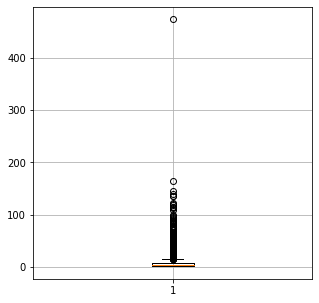

In [ ]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize =(5, 5)) 
# Creating plot 
plt.boxplot(  tfidf_of_each_words.sum(axis=0)  ) 

plt.grid("whitegrid")
# show plot 
plt.show()

In [ ]:

x_train_word_df = pd.DataFrame(  tfidf_of_each_words.sum(axis=0) ,columns=['TF_IDF'])
x_train_word_df['Features'] = tfidf_vec_essay.get_feature_names()

In [ ]:
top_words = x_train_word_df[ x_train_word_df['TF_IDF'] < 4 ]
top_words = top_words[ top_words['TF_IDF'] > 2 ]

top_words['Features'].values.shape

(1079,)

In [ ]:
#sorted_ifidf['Features'].values[0:10]

sorted_ifidf = top_words.sort_values(by=['TF_IDF'] , ascending=False )
vocab_dict = {}

for i , k in enumerate(sorted_ifidf['Features'].values):
  vocab_dict[k] = i

In [ ]:
#list(vocab_dict)[0:10] , len(vocab_dict)

In [ ]:
#after removing low and high tf-idf words
tfidf_best_thresold_words = TfidfVectorizer(vocabulary= vocab_dict )
tfidf_best_thresold_words.fit(X_train['essay'].values)
X_train_best_thresold_tfidf = tfidf_best_thresold_words.transform(X_train['essay'].values)
X_train_best_thresold_tfidf = X_train_best_thresold_tfidf.toarray()


school_state_vect = TfidfVectorizer()
school_state_vect.fit( X_train['school_state'].values )
school_state_t = school_state_vect.transform( X_train['school_state'].values )
school_state_t = school_state_t.toarray()


teacher_prefix_vec_t = TfidfVectorizer()
teacher_prefix_vec_t.fit( X_train['teacher_prefix'].values)
teacher_prefix_t = teacher_prefix_vec_t.transform( X_train['teacher_prefix'].values )
teacher_prefix_t = teacher_prefix_t.toarray()

project_grade_category_vec_t = TfidfVectorizer()
project_grade_category_vec_t.fit( X_train['project_grade_category'].values )
project_grade_category_t = project_grade_category_vec_t.transform( X_train['project_grade_category'].values )
project_grade_category_t = project_grade_category_t.toarray()

clean_categories_vec_t = TfidfVectorizer()
clean_categories_vec_t.fit( X_train['clean_categories'].values )
clean_categories_t = clean_categories_vec_t.transform( X_train['clean_categories'].values )
clean_categories_t = clean_categories_t.toarray()

clean_subcategories_vec_t = TfidfVectorizer()
clean_subcategories_vec_t.fit( X_train['clean_subcategories'].values )
clean_subcategories_t = clean_subcategories_vec_t.transform( X_train['clean_subcategories'].values )
clean_subcategories_t = clean_subcategories_t.toarray()

In [ ]:
#temp = np.array([1.48,1.41,0.0,0.1])
#print( np.argsort(temp) )
X_train_best_thresold_tfidf.shape ,school_state_t.shape,teacher_prefix_t.shape ,\
project_grade_category_t.shape , \
clean_categories_t.shape, clean_subcategories_t.shape

((3350, 1079), (3350, 51), (3350, 4), (3350, 4), (3350, 7), (3350, 28))

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'

tf.keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

input_layer1 = Input(shape=(X_train_best_thresold_tfidf.shape[0],),name='input_seq_total_text_data')
embedding1 = Embedding(100, 2, input_length= X_train_best_thresold_tfidf.shape[0] )(input_layer1)
lstm1 = LSTM(128)(embedding1)
flatten = Flatten(name='flatten')(lstm1)

input_layer2 = Input(shape=(51,),name='input_school_state')
embedding2 = Embedding(51, 2, input_length=51 )(input_layer2)
flatten1 = Flatten(name='flatten1')(embedding2)

input_layer3 = Input(shape=(4,),name='project_grade_category')
embedding3 = Embedding(5, 2, input_length=4 )(input_layer3)
flatten2 = Flatten(name='flatten2')(embedding3)

input_layer4 = Input(shape=(7,),name='input_clean_categories')
embedding4 = Embedding(4, 2, input_length=7 )(input_layer4)
flatten3 = Flatten(name='flatten3')(embedding4)

input_layer5 = Input(shape=(28,),name='input_clean_subcategories')
embedding5 = Embedding(10, 2, input_length=28 )(input_layer5)
flatten4 = Flatten(name='flatten4')(embedding5)

input_layer6 = Input(shape=(4,),name='input_teacher_prefix')
embedding6 = Embedding(4, 2, input_length=4 )(input_layer6)
flatten5 = Flatten(name='flatten5')(embedding6)

input_layer7 = Input(shape=(1,),name='input_numerical')
input7 = Dense(units=1,activation='relu',kernel_initializer='he_normal',name='dense_for_rem_input')(input_layer7)

concat = concatenate([flatten, flatten1, flatten2, flatten3, flatten4, flatten5, input7])

concat_dense = Dense(units=351,activation='relu',kernel_initializer='he_normal',name='concat_dense')(concat)

dropout_0 = Dropout(0.5)(concat_dense)

dense2 = Dense(units=64,activation='relu',kernel_initializer='he_normal',name='dense2')(dropout_0)

dropout_1 = Dropout(0.5)(dense2)

dense3 = Dense(units=16,activation='relu',kernel_initializer='he_normal',name='dense3')(dropout_1)

Out = Dense(units=1,activation='softmax',kernel_initializer='glorot_uniform' ,name='Output')(dense3)

model2 = Model( inputs=[input_layer1, input_layer2, input_layer3 , input_layer4 , input_layer5, input_layer6 ,input_layer7 ],
                outputs=[Out] )

model2.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy' ,auc_score ],
)

In [ ]:
X_train_price_norm = X_train_price_norm.reshape(-1,1)

In [ ]:
X_train_best_thresold_tfidf[0:,0:16].toarray().shape

(3350, 16)

In [ ]:
model2.fit({"input_seq_total_text_data": X_train_best_thresold_tfidf , "input_school_state": school_state_t, 
           "project_grade_category": project_grade_category_t
           ,"input_clean_categories": clean_categories_t, "input_clean_subcategories" : clean_subcategories_t ,
           "input_teacher_prefix" : teacher_prefix_t,
           "input_numerical" : X_train_price_norm.reshape(-1,1) } ,
          {"Output": y_train.reshape(-1,1) }
          , batch_size=64, epochs=5 )

Epoch 1/5
53/53 [==============================] - 90s 2s/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000
Epoch 2/5
53/53 [==============================] - 90s 2s/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000
Epoch 3/5
53/53 [==============================] - 94s 2s/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000
Epoch 4/5
53/53 [==============================] - 90s 2s/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000
Epoch 5/5
53/53 [==============================] - 91s 2s/step - loss: 0.0000e+00 - accuracy: 0.8657 - auc_score: 0.5000


### Model-3

In [ ]:
glove_path_ = ''

with open( glove_path_ + 'glove_vectors', 'rb') as f:
    glove_model = pickle.load(f)
    glove_words =  set( glove_model.keys() )


In [ ]:
len( glove_words ), glove_model.get('the').shape[0]

(51510, 300)

In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
#X_train , X_test , y_train , y_test = train_test_split( X , y , test_size=0.33,stratify=y)

In [ ]:
X['essay'][0]

'i fortunate enough use fairy tale stem kits classroom well stem journals students really enjoyed i would love implement lakeshore stem kits classroom next school year provide excellent engaging stem lessons my students come variety backgrounds including language socioeconomic status many not lot experience science engineering kits give materials provide exciting opportunities students each month i try several science stem steam projects i would use kits robot help guide science instruction engaging meaningful ways i adapt kits current language arts pacing guide already teach material kits like tall tales paul bunyan johnny appleseed the following units taught next school year i implement kits magnets motion sink vs float robots i often get units not know if i teaching right way using right materials the kits give additional ideas strategies lessons prepare students science it challenging develop high quality science activities these kits give materials i need provide students science 

In [ ]:
text_ = X['essay'].tolist()   #data_df_all['preprocessed_text_all'].tolist()

token_ = Tokenizer()
token_.fit_on_texts( text_ )

vocab_size = len(token_.word_index) + 1

encoded_text = token_.texts_to_sequences( text_ )

max_length = 300
X_ = pad_sequences( encoded_text , maxlen= max_length , padding='post')


In [ ]:
X_train , X_test , y_train , y_test = train_test_split( X_ , y , test_size=0.33,stratify=y )

In [ ]:
def get_word_vector_matrix( vocab_size , token_ , glove_model ):

  word_vector_matrix = np.zeros( ( vocab_size , glove_model.get('the').shape[0] ) )
  vec_count_non_0 = 0
  for word , indax in token_.word_index.items():
      vector = glove_model.get( word )
      if vector is not None :
        word_vector_matrix[ indax ] = vector
        vec_count_non_0 += 1

  return word_vector_matrix

word_vector_matrix = get_word_vector_matrix( vocab_size , token_ , glove_model )
vec_size = word_vector_matrix.shape[1]

In [ ]:

tf.keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

input_layer1 = Input(shape=(300,),name='input_seq_total_text_data')
#embedding1 = Embedding( 4, 2, input_length= 300 )(input_layer1)
embedding1 = Embedding( vocab_size , vec_size , input_length=max_length , weights=[word_vector_matrix] )( input_layer1 )
lstm1 = LSTM(128)(embedding1)
flatten = Flatten(name='flatten')(lstm1)

#input_layer2 = Input(shape=(1501,1),name='other_than_text')
input_layer2 = Input(shape=(1500,1),name='other_than_text')
'''Conv1 = Conv2D(filters=4,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv1')(input_layer2)
'''
Conv1 = Conv1D(16, 3, 3 , activation="relu" )(input_layer2)
'''
Conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=5),name='Conv2')(Conv1)
'''
Conv2 = Conv1D(8, 3, 3 , activation="relu")(Conv1)

flatten1 = Flatten(name='flatten1')(Conv2)

concat = concatenate([flatten, flatten1 ])

concat_dense = Dense(units=32,activation='relu',kernel_initializer='he_normal',name='concat_dense')(concat)

dropout_0 = Dropout(0.5)(concat_dense)

dense2 = Dense(units=64,activation='relu',kernel_initializer='he_normal',name='dense2')(dropout_0)

dropout_1 = Dropout(0.5)(dense2)

dense3 = Dense(units=16,activation='relu',kernel_initializer='he_normal',name='dense3')(dropout_1)

Out = Dense(units=1,activation='softmax',kernel_initializer='glorot_uniform' ,name='Output')(dense3)

model3 = Model( inputs=[input_layer1, input_layer2 ],
                outputs=[Out] )

model3.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy' ],
)

In [ ]:
model3.summary()

In [ ]:
from tqdm import tqdm

In [ ]:
'''
glove_path_ = ''

with open( glove_path_ + 'glove_vectors', 'rb') as f:
    glove_model = pickle.load(f)
    glove_words =  set( glove_model.keys() )
'''

def compute_TFIDF_W2V(preprocessed_data):

  tfidf_model = TfidfVectorizer()
  tfidf_model.fit(preprocessed_data)
  # we are converting a dictionary with word as a key, and the idf as a value
  dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
  tfidf_words = set(tfidf_model.get_feature_names())
  # compute average word2vec for each review.
  tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(preprocessed_data): # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if (word in glove_words) and (word in tfidf_words):
              vec = glove_model[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
  
  return np.array(tfidf_w2v_vectors)

In [ ]:
other_text = data.drop(['project_is_approved','essay'], axis=1)
X_tr_ot , X_te_ot , y_tr_ot , y_te_ot = train_test_split( other_text , y , test_size=0.33,stratify=y)

In [ ]:
X_tr_ot.head(1)

In [ ]:
print("Data model for Other Text")
#X_train_essay_tfidfw2v = compute_TFIDF_W2V( X_train['essay'].values )

X_train_state_tfidfw2v = compute_TFIDF_W2V( X_tr_ot['school_state'].values )
X_train_teacher_tfidfw2v = compute_TFIDF_W2V( X_tr_ot['teacher_prefix'].values )
X_train_grade_tfidfw2v = compute_TFIDF_W2V( X_tr_ot['project_grade_category'].values  )
X_train_category_tfidfw2v = compute_TFIDF_W2V( X_tr_ot['clean_categories'].values )
X_train_subcat_tfidfw2v = compute_TFIDF_W2V( X_tr_ot['clean_subcategories'].values )

normalizer_p = Normalizer()
normalizer_p.fit(X_tr_ot['price'].values.reshape(-1,1))
X_train_price_norm = normalizer_p.transform(X_tr_ot['price'].values.reshape(-1,1))



100%|██████████| 3350/3350 [00:00<00:00, 412086.65it/s]

Data model for Other Text



100%|██████████| 3350/3350 [00:00<00:00, 118857.00it/s]


In [ ]:
#X_train_subcat_tfidfw2v.shape , X_tr_tfidfw2v.shape

In [ ]:
#X_train_state_tfidfw2v[0].shape

(300,)

In [ ]:
#adding each feature to horizontal
X_tr_tfidfw2v = np.hstack(( X_train_state_tfidfw2v , X_train_teacher_tfidfw2v , X_train_grade_tfidfw2v , \
               X_train_category_tfidfw2v, X_train_subcat_tfidfw2v , \
               X_train_price_norm.reshape(-1,1)  ))

In [ ]:
# reshape of all features for convd1

X_tr_tfidfw2v = X_tr_tfidfw2v.reshape( X_tr_tfidfw2v.shape[0] , X_tr_tfidfw2v.shape[1] , 1 )
X_train.shape , X_tr_tfidfw2v.shape 

((3350, 300), (3350, 1501, 1))

In [ ]:
# shape of all features together and shape of text feature
#X_tr_tfidfw2v.shape , X_train_essay_tfidfw2v.shape

((3350, 1501, 1), (3350, 300))

In [ ]:
X_te_state_tfidfw2v = compute_TFIDF_W2V( X_te_ot['school_state'].values )
X_te_teacher_tfidfw2v = compute_TFIDF_W2V( X_te_ot['teacher_prefix'].values )
X_te_grade_tfidfw2v = compute_TFIDF_W2V( X_te_ot['project_grade_category'].values  )
X_te_category_tfidfw2v = compute_TFIDF_W2V( X_te_ot['clean_categories'].values )
X_te_subcat_tfidfw2v = compute_TFIDF_W2V( X_te_ot['clean_subcategories'].values )

normalizer_p = Normalizer()
normalizer_p.fit(X_te_ot['price'].values.reshape(-1,1))
X_te_price_norm = normalizer_p.transform(X_te_ot['price'].values.reshape(-1,1))

X_te_tfidfw2v = np.hstack(( X_te_state_tfidfw2v , X_te_teacher_tfidfw2v , X_te_grade_tfidfw2v , \
               X_te_category_tfidfw2v, X_te_subcat_tfidfw2v , \
               X_te_price_norm.reshape(-1,1)  ))

X_te_tfidfw2v = X_te_tfidfw2v.reshape( X_te_tfidfw2v.shape[0] , X_te_tfidfw2v.shape[1] , 1 )
X_te_tfidfw2v.shape

100%|██████████| 1650/1650 [00:00<00:00, 119754.31it/s]


(1650, 1501, 1)

In [ ]:
model3.fit({"input_seq_total_text_data": X_train , 
            "other_than_text": X_tr_tfidfw2v } ,
          {"Output": y_train } , 
           validation_data =( {"input_seq_total_text_data": X_test , "other_than_text": X_te_tfidfw2v } ,
          {"Output": y_test } )
          , batch_size=50, epochs=3 ,validation_batch_size=50)

Epoch 1/3
67/67 [==============================] - 5s 68ms/step - loss: 0.0000e+00 - accuracy: 0.8657 - val_loss: 0.0000e+00 - val_accuracy: 0.8661
Epoch 2/3
67/67 [==============================] - 4s 60ms/step - loss: 0.0000e+00 - accuracy: 0.8657 - val_loss: 0.0000e+00 - val_accuracy: 0.8661
Epoch 3/3
67/67 [==============================] - 4s 61ms/step - loss: 0.0000e+00 - accuracy: 0.8657 - val_loss: 0.0000e+00 - val_accuracy: 0.8661
